In [1]:
# parametry do testowania funkcji

C_ZeroWeights = True        # True -  symulacja drzewa decyzyjnego czyli zerowanie wag (set_weights)
C_WeightDivision = None     # zmniejszanie wag węzłów potomnych (GDY NIE SYMULUJEMY DRZEWA) (set_weights)
C_EntropyThreshold = 0      # Kryterium stopu - entropia, który określa moment zakończenia podziału (build_tree)
C_IgThreshold =  0          # kryterium stopu - IG, który określa moment wykonania podziału  (build_tree)
C_MissingValue = 'mv'       # wartość wstawiana w miejsce brakujących danych
C_Dataset = 'zoo'           # do testów kodu

# zmienne globalne

DEBUG = True                # True - wyświetla komunikaty do debugowania
DF_DATA = None
X = None 
y = None
TN_ROOT = None

In [2]:
# import + debug

from sklearn.datasets import fetch_openml
import pandas as pd

import numpy as np
import math
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

def DEBUGprint(flag = False, text = None, value = None, typ = True):
    if flag:
        print('DEBUG', text)
        print('>>>>>', value, end =' ')
        if typ:
            print(type(value))
        print()

In [3]:
# pobranie danych

def data_load(file_name = None):
    print('File name: ', file_name)
    if file_name != "sample":
        _file_set = fetch_openml(name = file_name)
        _DF = pd.DataFrame(data = _file_set.data, columns = _file_set.feature_names)
        _DF['target'] = _file_set.target
    elif file_name == "sample":
        _S_a1 = pd.Series(["a", "a", "b", "b", "b"], name = "A1")
        _S_a2 = pd.Series(["c", "d", "c", "d", "d"], name = "A2")
        _S_a3 = pd.Series(["e", "f", "f", "f", "e"], name = "A3")
        _S_c = pd.Series(["C1", "C1", "C2", "C2", "C3"], name = "target")
        _DF = pd.concat([_S_a1, _S_a2, _S_a3, _S_c], axis = 1)
    return _DF

In [4]:
DF_DATA = data_load(C_Dataset)
DEBUGprint(DEBUG,'wymiar danych:', DF_DATA.shape)

File name:  zoo
DEBUG wymiar danych:
>>>>> (101, 17) <class 'tuple'>



In [5]:
# preprocessing

# zamiana NaN na stałą zdefiniowaną jako C_MissingValue
# modyfikacja parametru df
def missing_values(df: pd.DataFrame):
    for _col in df.columns:
        if df[_col].isna().sum() > 0:
            DEBUGprint(DEBUG,'missing values (wykryto NaN w kolumnie o nazwie): ', _col)
            df[_col] = df[_col].cat.add_categories([C_MissingValue])
            df[_col].fillna(value = C_MissingValue, inplace=True)      

            
# zamiana non strings na strings
# modyfikacja parametru df           
def numbers(df: pd.DataFrame):
    for _col in df.columns:
        if not all(isinstance(_x, str) for _x in df[_col]):
            DEBUGprint(DEBUG,'numbers (wykryto non string w kolumnie o nazwie): ', _col)
            DEBUGprint(DEBUG,'numbers (stare wartości): ', df[_col].iloc[0])
            df[_col] = df[_col].astype(str)
            DEBUGprint(DEBUG,'numbers (nowe wartości): ', df[_col].iloc[0])

            
# usuwanie klasy poniżej 10 przykładów
# modyfikacja parametru df
def rare_labels(df: pd.DataFrame):
    _counts = df['target'].value_counts()
    _to_remove = _counts[_counts < 10].index
    DEBUGprint(DEBUG,'rare_labels (usuwane wartości): ',_to_remove.values, typ = False)
    DEBUGprint(DEBUG,'rare_labels (liczność): ',_counts[_counts < 10].values, typ = False)
    df.drop(df[df['target'].isin(_to_remove)].index, inplace=True)

In [6]:
missing_values(DF_DATA)

In [7]:
numbers(DF_DATA) 

DEBUG numbers (wykryto non string w kolumnie o nazwie): 
>>>>> legs <class 'str'>

DEBUG numbers (stare wartości): 
>>>>> 4.0 <class 'numpy.float64'>

DEBUG numbers (nowe wartości): 
>>>>> 4.0 <class 'str'>



In [8]:
rare_labels(DF_DATA)
DEBUGprint(DEBUG,'rare_labels (po usunięciu):',DF_DATA['target'].value_counts())

DEBUG rare_labels (usuwane wartości): 
>>>>> ['insect', 'reptile', 'amphibian']
Categories (7, object): ['amphibian', 'bird', 'fish', 'insect', 'invertebrate', 'mammal', 'reptile'] 
DEBUG rare_labels (liczność): 
>>>>> [8 5 4] 
DEBUG rare_labels (po usunięciu):
>>>>> target
mammal          41
bird            20
fish            13
invertebrate    10
amphibian        0
insect           0
reptile          0
Name: count, dtype: int64 <class 'pandas.core.series.Series'>



In [9]:
class TreeNode:
      
    # inicjowanie węzła z identyfikatorem
    # n_id = None, bo przy ocenie testu nie musimy podawać wartości parametru
    def __init__(self, n_id = None):
        self.node_id = n_id
        self.weights = None     # (SERIES) tablica WARTOSĆI WAG każdego przykładu uczącego  
        self.entropy = None     # wartość entropii w tym węźle 
        self.ig = None
        self.mark_value = None  # WYNIK TESTU prowadzący do węzła od rodzica
        self.mark_col = None    # NAZWA TESTU użytego w węźle
        self.used_columns = []
        self.children = dict()  # Słownik przechowujący węzły potomne
        self.leaf = False       # gdy węzeł staje się liściem: ETYKIETA z największą sumą wag
  
    
    # inicjowanie tablicy WARTOŚCI WAG wartościami "1"
    def init_weights(self, X: pd.DataFrame):
        weights = pd.Series([1] * len(X), index = X.index)  # indeksy tablicy takie jak indeksy przykładów w X 
        self.weights = weights
        #DEBUGprint(DEBUG,'init_weights (weights):',self.weights)
        return self
        
        
    # modyfikowanie wag węzła na podstawie podanej col_name i wartości value
    def set_weights(self, X: pd.DataFrame, y: pd.Series, col_name = None , value = None):
        #DEBUGprint(DEBUG,'set_weights (wagi przed):',self.weights)  
        for _index, _value in X[col_name].items():                
            if _value != value:                                   # jeśli wartości się różnią
                if C_ZeroWeights:
                    self.weights[_index] = 0                      # zerowanie wag
                else:
                    self.weights[_index] /= C_WeightDivision      # dzielenie wag przez ustaloną wartość (np. 100, 1000 itd.)
        #DEBUGprint(DEBUG,'set_weights (wagi po):',self.weights)    

        
    # oznaczanie węzła jako liść: etykieta z największą sumą wag !!!
    def mark_leaf(self, X: pd.DataFrame, y: pd.Series):
        _DF_target_weight = pd.DataFrame({'target': y, 'weight': self.weights})   
        _S_target_weights = _DF_target_weight.groupby('target')['weight'].sum(numeric_only=False)
        self.leaf = _S_target_weights.idxmax()                # wyznacza ETYKIETĘ z największą sumą wag
        #DEBUGprint(DEBUG,'mark_leaf (leaf):',self.leaf) 
        print('l',end='')
        
    # wyznaczenie entropi w oparciu o wartości wagi węzła
    def set_entropy(self, X: pd.DataFrame, y: pd.Series): 
        _entropy = 0
        _weights_sum = sum(self.weights)                          # suma wag       
        _DF_target_weight = pd.DataFrame({'target': y, 'weight': self.weights})        
        _S_target_weights = _DF_target_weight.groupby('target')['weight'].sum(numeric_only=False) 
        if _weights_sum != 0:                               # suma wag może być równa 0, wtedy entropia = 0 !!!
            for _tweight in _S_target_weights:              # dla kazdej sumy wag dla etykiety
                if _tweight != 0:                           # suma wag dla etykiety może być równa 0, wtedy wyrazenie = 0 !!!
                    _p = _tweight/_weights_sum   
                    _entropy += -_p * math.log(_p,2)
        self.entropy = _entropy 
        #DEBUGprint(DEBUG,'set_entropy (DF przed grupowaniem):', _DF_target_weight)
        #DEBUGprint(DEBUG,'set_entropy (S po grupowaniu i sumowaniu):', _S_target_weights)
        #DEBUGprint(DEBUG,'set_entropy (entropia):', _entropy)
 

    # wyznaczanie IG
    def information_gain(self, X: pd.DataFrame, y: pd.Series, col_name = None):
        _node_entropy = self.entropy                        # odczyt entropii dla węzła
        _aggregated_entropy = 0                             # zagregowana entrpia dla dzieci
        _children_weights_sum = 0                           # suma wag po dzieciach
        #DEBUGprint(DEBUG,'information_gain (X[col_name]):', X[col_name] )
        _names, _count = np.unique(X[col_name].astype(str),return_counts=True) 
        for _value in _names:                               # dla każdej wartości testu mamy potencjalnego potomka !!!
            _child_node = TreeNode()                        # >>>>>>>>>>  NEW NODE <<<<<<<<<<<<<
            _child_node.weights = self.weights.copy()       # kopia wag
            _child_node.set_weights(X,y, col_name, _value)  # zmiana wag  
            _child_node.set_entropy(X,y)          
            _aggregated_entropy +=  sum(_child_node.weights) * _child_node.entropy
            _children_weights_sum += sum(_child_node.weights)
            del(_child_node)
        if _children_weights_sum != 0:
            _aggregated_entropy /= _children_weights_sum 
        else:
            DEBUGprint(DEBUG,'WARNING information_gain (_aggregated_entropy):', _aggregated_entropy) 
        return (_node_entropy - _aggregated_entropy)
 

    # znajdź test (najbardziej użyteczny TEST w oparciu o IG)
    def find_test(self, X: pd.DataFrame, y: pd.Series):
        _L_columns = []                                   # lista testowanych kolumn
        _L_values = []                                    # lista wartości IG
        for _col_name in X.columns:                       # przeglądamy kolumny
            if _col_name not in self.used_columns:        # pomijamy użyte kolummny
                _ig = self.information_gain(X,y,_col_name)        # oblicz IG dla danej kolumny
                _L_columns.append(_col_name)                         
                _L_values.append(_ig)
                #DEBUGprint(DEBUG,'find_test (name):',_col_name)
                #DEBUGprint(DEBUG,'find_test (IG):',_ig) 
        _best_col_name =  _L_columns[_L_values.index(max(_L_values))]      # najlepszy test
        #DEBUGprint(DEBUG,'find_test (most usefull test):',_best_col_name)
        return _best_col_name, max(_L_values)  

In [10]:
# funkcje związane z drzewem

# budowa drzewa
def build_tree(X: pd.DataFrame, y: pd.Series):  
    print('Building:',end='')
    
    _L_unmarked_nodes = []          # lista nieoznaczonych węzłów
    _entropy_endings = 0            # liczba węzłów oznaczonych jako liść - kryterium stopu dla węzła (entropia)
    _ig_endings = 0                 # liczba węzłów oznaczonych jako liść - kryterium stopu dla atrybutu (IG)
    _data_endings = 0               # liczba węzłów oznacznych jako liść - kryterium stopu brak atrybutów
    _node_id = 0
    
    # Krok 1: inicjowanie korzenia i listy nieoznaczonych węzłów
    _TN_root = TreeNode(_node_id)                           # >>>>>>>>>>  NEW NODE <<<<<<<<<<<<<
    _node_id += 1
    _TN_root.init_weights(X)                                # inicjowanie tablicy wartości wag
    _L_unmarked_nodes = [_TN_root]                          # inicjowanie listy nieoznaczonych węzłów

    # Krok 2: analiza nieoznaczonych węzłów
    while len(_L_unmarked_nodes) > 0:                       # dopóki są nieoznaczone węzły      
        _TN_node = _L_unmarked_nodes.pop(0)                 # pobierz z listy pierwszy węzeł  
        _TN_node.set_entropy(X,y)                           # oblicz entropię dla węzła  
        
        # Kryterium stopu dla węzła: w oparciu o entropię
        if _TN_node.entropy <= C_EntropyThreshold:          # STOP !!!
            _TN_node.mark_leaf(X,y)                         # oznaczenie węzła jako liścia
            _entropy_endings += 1                           
            continue   
        
        # Kryterium stopu dla węzła: brak testów 
        if len(_TN_node.used_columns) >= len(X.columns):    # STOP !!! 
            _TN_node.mark_leaf(X,y)                         # oznaczenie węzła jako liścia 
            _data_endings += 1                                 
            continue
                           
        # Wybranie najbardziej użytecznego testu
        _col_name, _ig = _TN_node.find_test(X,y)            # szukamy najlepszego testu
        
        # Kryterium stopu dla węzła: w oparciu o IG 
        if _ig <= C_IgThreshold:                            # STOP !!!
                _TN_node.mark_leaf(X,y)                     # Oonaczenie węzła jako liścia
                _ig_endings += 1
                continue
        
         # Dodanie testu do drzewa
        _TN_node.mark_col = _col_name                       # węzeł: przypisanie TESTU do węzła
        _TN_node.ig = _ig                                   # węzeł: przypisanie oceny TESTU do węzła
        _TN_node.used_columns.append(_col_name)             # węzeł: dodanie TESTU do listy użytych testów
        _TN_node.children = dict()                          # Słownik przechowujący węzły potomne
        for _test_value in X[_col_name].unique():    
                _TN_child = TreeNode(_node_id)                                # >>>>>>>>>>  NEW NODE <<<<<<<<<<<<<
                _node_id += 1
                _TN_child.weights = _TN_node.weights.copy()                   # utworzenie węzła potomnego z kopią wag
                _TN_child.set_weights(X,y,_TN_node.mark_col, _test_value)     # ustawienie wag dla węzła potomnego
                _TN_child.mark_value = _test_value                            # przypisanie wartości atrybutu do węzła potomnego
                _TN_child.used_columns = _TN_node.used_columns.copy()         # kopia użytych kolumn/testów
                _TN_node.children[_test_value] = _TN_child                    # dodanie węzła potomnego do słownika
                _L_unmarked_nodes.append(_TN_child)                           # dodanie węzła potomnego do listy węzłów nieoznaczonych 
            
    print('Stop criterion (leaves):', end=' ')
    print("(entropy)", _entropy_endings,  end=' ') # wyświetlenie liczby kryterium stopu - Entropia 
    print("(IG)", _ig_endings,  end=' ') # wyświetlenie liczby kryterium stopu - IG
    print("(no test)", _data_endings) # wyświetlenie liczby kryterium stopu - koniec danych
    return _TN_root   

# wyświetlenie drzewa
def print_tree(node: TreeNode, level=0):
    _test_value = node.mark_value     # wynik testu węzła rodzica
    _test_name = node.mark_col        # nazwa testu w wężle   
    _nodes = 1                       # Licznik węzłów
    if _test_value is None:  # root
        _line = level*"\t" + _test_name+ \
        ' ['+"{:.1f}".format(sum(node.weights))+": "+"{:.2f}".format(node.entropy)+">"+"{:.2f}".format(node.ig)+"]"
    else:
        _line = level*"\t"+str(_test_value)+"->"+  _test_name + \
        ' ['+"{:.1f}".format(sum(node.weights))+": "+"{:.2f}".format(node.entropy)+">"+"{:.2f}".format(node.ig)+"]"
    print(_line) 
    for _TN_child in node.children.values():    # Iteracja przez wszystkich potomków
        if _TN_child.leaf is not False:          # gdy jest liściem
            _nodes += 1
            _line = (1 + level)*"\t"+ str(_TN_child.mark_value)+"->"+ \
            str(_TN_child.leaf)   + \
            " [" + "{:.1f}".format(sum(_TN_child.weights))+": "+"{:.2f}".format(_TN_child.entropy)+"]"     
            print(_line)
        else:                                 #gdy ma węzły potomne           
            _nodes += print_tree(_TN_child, level + 1) # Rekurencyjne wywołanie dla dzieci węzła
    return _nodes


from graphviz import Digraph
import random as r

def random_graph_colors(y: pd.Series):
    color_dict = {}
    for i in y.unique():
        color_dict[i] = f'#{hex(r.randrange(50,175))[2:]}'\
                        f'{hex(r.randrange(50,175))[2:]}'\
                        f'{hex(r.randrange(50,175))[2:]}' #wylosuj wartosci RGB i przedstaw jako #XXXXXX
    print(color_dict)
        
    return color_dict

def brighten_color(current_color):
    r_brighter = hex(int(int(current_color[1:3],16)*1.4))
    g_brighter = hex(int(int(current_color[3:5],16)*1.4))
    b_brighter = hex(int(int(current_color[5:],16)*1.4))
    
    return f'#{r_brighter[2:]}{g_brighter[2:]}{b_brighter[2:]}'


def create_tree_graph(node: TreeNode, y:pd.Series, color_dict, graph=None, parent_name=None, level=0):
    if graph is None:     #atrybuty grafu
        graph = Digraph(comment='Decision Tree')
        graph.attr(ranksep='1.5')
        graph.attr(nodesep='0.5')
        graph.attr(size='11.0,5.0')      

    test_value = node.mark_value
    test_name = node.mark_col
    
    target_weight = pd.DataFrame({'target': y, 'weight': node.weights})                       #fragment sluzacy
    grouped_target_weight = target_weight.groupby('target')['weight'].sum(numeric_only=False) #obliczaniu najczesciej wystepujacej
    most_frequent_class_in_node = grouped_target_weight.idxmax()                              #kategorii w wezle niebedacym lisciem

    if test_value is None:  # root
        node_label = f'Entropy: {node.entropy:.2f} \n Next test: {test_name}'
        #node_label = f'{test_name} \n [{sum(node.weights):.1f}: {node.entropy:.2f}>{node.ig:.2f}]'
    else:
        node_label = f'{test_value}->{test_name} \n [{sum(node.weights):.1f}: {node.entropy:.2f}>{node.ig:.2f}] \n' \
                     f'{most_frequent_class_in_node}'
        
    graph.node(str(id(node)), label=node_label, fontsize='11', shape='rectangle', \
               color='black', style='filled', fillcolor=brighten_color(color_dict[most_frequent_class_in_node]))

    if parent_name is not None:
        graph.edge(parent_name, str(id(node)), label=node.mark_value)

    for child_name, child_node in node.children.items():
        if child_node.leaf is not False:  # when it's a leaf
            leaf_label = f'{child_node.mark_value}->{child_node.leaf} \n ' \
                         f'[{sum(child_node.weights):.1f}: {child_node.entropy:.2f}] \n {child_node.leaf}'
            graph.node(str(id(child_node)), label=leaf_label, fontsize='11', shape='rectangle', \
                        color='black', style='filled', fillcolor=color_dict[child_node.leaf]) 
            #!!!dla datasetu audiology tu sie wywala na plecy (dokladnie dla atrybutu fillcolor),
            #bo wstawiana jest jako najliczniejsza etykieta, ktora, z tego co rozumiem, powinna juz byc usunieta
            graph.edge(str(id(node)), str(id(child_node)), label=child_node.mark_value)
        else:  # when it has child nodes
            create_tree_graph(child_node, y, color_dict, graph, str(id(node)), level + 1)

    return graph

# przechodzi przez drzewo decyzyjne, aby przewidzieć etykietę na podstawie danych wejściowych
def travel_tree(node: TreeNode, s_example: pd.Series,_current_cost = None):
    if node.leaf is not False:
        return node.leaf, _current_cost 
    else:     # Rekurencyjnie przechodzi przez drzewo
        _test = node.mark_col
        _test_result = s_example[_test]
        _new_cost = _current_cost + 1
        #_child = node.children[_test_result]   #szukamy węzła - MOZE GO NIE BYC !!!
        _child = node.children.get(_test_result, next(iter(node.children.values())))  #w razie braku testu pierwszy test !!!
        return travel_tree(_child,s_example,_new_cost)
    
# wyznacza trafność drzewa reprezentowanego przez node dla danych X,y
def score_tree(node: TreeNode, X, y):
    _good = 0                                            # licznik poprawnych przewidywań
    _sum_cost=0
    for _i in range(len(X)):
        _predicted,_example_cost = travel_tree(node,X.iloc[_i],0)
        _expected = y.iloc[_i]  
        if _predicted == _expected:
            _good += 1
        _sum_cost += _example_cost
    _accuracy = _good / len(X)  
    return _accuracy, _sum_cost    

In [11]:
# podział na X oraz Y
X = DF_DATA.iloc[:, :-1]  
y = DF_DATA.iloc[:, -1] 

display(X, type(X))
display(y,type(y))

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,true,false,false,true,false,false,true,true,true,true,false,false,4.0,false,false,true
1,true,false,false,true,false,false,false,true,true,true,false,false,4.0,true,false,true
2,false,false,true,false,false,true,true,true,true,false,false,true,0.0,true,false,false
3,true,false,false,true,false,false,true,true,true,true,false,false,4.0,false,false,true
4,true,false,false,true,false,false,true,true,true,true,false,false,4.0,true,false,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,false,true,true,false,true,false,true,false,true,true,false,false,2.0,true,false,true
96,true,false,false,true,false,false,false,true,true,true,false,false,2.0,true,false,true
98,true,false,false,true,false,false,true,true,true,true,false,false,4.0,true,false,true
99,false,false,true,false,false,false,false,false,false,true,false,false,0.0,false,false,false


pandas.core.frame.DataFrame

0            mammal
1            mammal
2              fish
3            mammal
4            mammal
           ...     
95             bird
96           mammal
98           mammal
99     invertebrate
100            bird
Name: target, Length: 84, dtype: category
Categories (7, object): ['amphibian', 'bird', 'fish', 'insect', 'invertebrate', 'mammal', 'reptile']

pandas.core.series.Series

In [12]:
# Test poprawności działania 

MODEL = build_tree(X,y)
#node_count = print_tree(MODEL)
tree_graph = create_tree_graph(MODEL, y, random_graph_colors(y))
accuracy,test_cost = score_tree(MODEL, X, y)
print()
print('Node = (id) test [suma wag: entropia>ig]')
print('Leaf = (id) decyzja [suma wag: entropia]')
#print('Node count: ', node_count)
print('Accuracy: ', accuracy)
print('Cost: ','(sum)', test_cost,'(average)',test_cost/len(X))

Building:llllllllllStop criterion (leaves): (entropy) 10 (IG) 0 (no test) 0
{'mammal': '#4a3c6f', 'fish': '#54a56a', 'bird': '#3e55a7', 'invertebrate': '#848850'}

Node = (id) test [suma wag: entropia>ig]
Leaf = (id) decyzja [suma wag: entropia]
Accuracy:  1.0
Cost:  (sum) 179 (average) 2.130952380952381


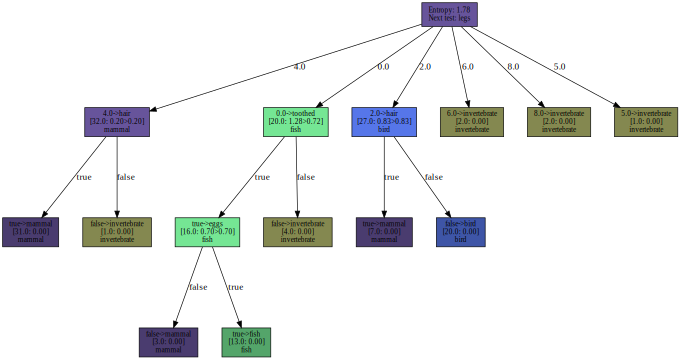

In [13]:
tree_graph

In [14]:
# potok wszystkich czynności
#domyślna konfiguracja to drzewo decyzyjne i test na zbiorze uczącym

def pipeline(file_set=['zoo'], 
             missing_v=True, numb=True, rare_l=True,             # preprocessing
             zero_weights=True, weight_division = 100000, e_thresh=0, ig_thresh=0,        # build
             print_t=False,                                      # print
             folds = 1,                                          # score
             debug=False, 
            ):
    global DEBUG, C_ZeroWeights, C_WeightDivision, C_EntropyThreshold, C_IgThreshold    
    DEBUG = debug
    C_ZeroWeights = zero_weights       
    C_WeightDivision = weight_division
    C_EntropyThreshold = e_thresh
    C_IgThreshold = ig_thresh

    for _filename in file_set:  
        _DF = data_load(_filename)     
        if missing_v:
            missing_values(_DF)
        if numb:
            numbers(_DF)    
        if rare_l:
            rare_labels(_DF)
    
        _X = _DF.iloc[:, :-1]
        _y = _DF.iloc[:, -1] 
    
        if folds == 1:
            _model = build_tree(_X,_y)
            if print_t:
                node_count = print_tree(_model)
                print()
                print('Node = [test),[suma wag],[entropia, ig]')
                print('Leaf = {decyzja},[suma wag],[entropia]')
                print("Node count: ", node_count)
            _score_acc, _score_cost= score_tree(_model, _X, _y)
            print('Accuracy: ', "{:.4f}".format(_score_acc))
            print('Cost: ','(sum)', _score_cost,'(average)',"{:.2f}".format(_score_cost/len(_X)))
            print()
        elif folds > 1:
            _skf = StratifiedKFold(n_splits=folds, shuffle=True,random_state=21)
            _scores_acc = []
            _scores_cost = []
            for _train, _test in _skf.split(_X, _y):
                _model = build_tree(_X.iloc[_train],_y.iloc[_train])
                if print_t:
                    node_count = print_tree(_model)
                    print()
                    print('Node = [test),[suma wag],[entropia, ig]')
                    print('Leaf = {decyzja},[suma wag],[entropia]')
                    print("Node count: ", node_count)
                _score_acc, _score_cost = score_tree(_model,_X.iloc[_test],_y.iloc[_test])
                _scores_acc.append(_score_acc) 
                _scores_cost.append(_score_cost/len(_test)) 
            print( 'Accuracy (average): ',_scores_acc,  end=', ')
            print( "{:.4f}".format(sum(_scores_acc) / len(_scores_acc))  )
            print('Cost (average): ',_scores_cost,  end=', ')
            print("{:.2f}".format( sum(_scores_cost) / len(_scores_cost)) )
            print()
            

In [15]:
# Test poprawności działania 
# 'sample' i dzielenie wag przez 2

pipeline(file_set = ['sample'], rare_l=False, zero_weights=False, weight_division=2, e_thresh=0.2, ig_thresh=0.01, print_t=True)

File name:  sample
Building:lllllllStop criterion (leaves): (entropy) 0 (IG) 1 (no test) 6
A1 [5.0: 1.52>0.08]
	a->A3 [3.5: 1.38>0.03]
		e->A2 [2.5: 1.37>0.02]
			c->C1 [1.9: 1.24]
			d->C1 [1.9: 1.46]
		f->C1 [2.8: 1.32]
	b->A3 [4.0: 1.50>0.06]
		e->A2 [2.8: 1.57>0.03]
			c->C2 [1.9: 1.57]
			d->C3 [2.2: 1.53]
		f->A2 [3.2: 1.33>0.01]
			c->C2 [2.2: 1.22]
			d->C2 [2.6: 1.41]

Node = [test),[suma wag],[entropia, ig]
Leaf = {decyzja},[suma wag],[entropia]
Node count:  13
Accuracy:  1.0000
Cost:  (sum) 14 (average) 2.80



In [16]:
# Test poprawności działania
# drzewo decyzjne i overfitting

pliki = ['zoo','car','audiology', 'mushroom']
pipeline(file_set = pliki)

File name:  zoo
Building:llllllllllStop criterion (leaves): (entropy) 10 (IG) 0 (no test) 0
Accuracy:  1.0000
Cost:  (sum) 179 (average) 2.13

File name:  car
Building:llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllStop criterion (leaves): (entropy) 182 (IG) 0 (no test) 0
Accuracy:  1.0000
Cost:  (sum) 4715 (average) 2.73

File name:  audiology
Building:lllllllllllllllllllllllllllllllllllllllllllllStop criterion (leaves): (entropy) 45 (IG) 0 (no test) 0
Accuracy:  1.0000
Cost:  (sum) 674 (average) 3.99

File name:  mushroom
Building:lllllllllllllllllllllllllllllllllStop criterion (leaves): (entropy) 33 (IG) 0 (no test) 0
Accuracy:  1.0000
Cost:  (sum) 12380 (average) 1.52



In [17]:
# Eksperyment
# drzewo decyzyjne i walidacja krzyżowa

pliki = ['zoo','car','audiology']
pipeline(file_set = pliki, folds=10)

File name:  zoo
Building:llllllllllStop criterion (leaves): (entropy) 10 (IG) 0 (no test) 0
Building:llllllllllStop criterion (leaves): (entropy) 10 (IG) 0 (no test) 0
Building:lllllllllllStop criterion (leaves): (entropy) 11 (IG) 0 (no test) 0
Building:llllllllllStop criterion (leaves): (entropy) 10 (IG) 0 (no test) 0
Building:llllllllllStop criterion (leaves): (entropy) 10 (IG) 0 (no test) 0
Building:lllllllllStop criterion (leaves): (entropy) 9 (IG) 0 (no test) 0
Building:llllllllllStop criterion (leaves): (entropy) 10 (IG) 0 (no test) 0
Building:llllllllllStop criterion (leaves): (entropy) 10 (IG) 0 (no test) 0
Building:llllllllllStop criterion (leaves): (entropy) 10 (IG) 0 (no test) 0
Building:lllllllllStop criterion (leaves): (entropy) 9 (IG) 0 (no test) 0
Accuracy (average):  [1.0, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.875], 0.9764
Cost (average):  [2.0, 2.3333333333333335, 2.3333333333333335, 2.3333333333333335, 2.0, 2.25, 2.0, 2.25, 2.0, 1.625], 2.11

File n

In [ ]:
# Eksperyment
# wagi i walidacja krzyzowa
# obserwacje (zoo): dzielnik maleje -> liczba liści rośnie (IG) 
# obserwacje (car): dzielnik maleje -> stała liczba liści (brak testów)  

pliki = ['zoo','car']
dzielniki = [100000, 10000, 1000, 100, 10]
progi = [0.6, 0.3,0.1]
for plik in pliki:
    for dziel in dzielniki:
        for prog in progi:
            print(dziel, prog)                          
            pipeline(file_set = [plik], zero_weights=False, weight_division=dziel, ig_thresh=prog,folds=10)

100000 0.6
File name:  zoo
Building:lllllllllStop criterion (leaves): (entropy) 0 (IG) 9 (no test) 0
Building:lllllllllStop criterion (leaves): (entropy) 0 (IG) 9 (no test) 0
Building:lllllllllStop criterion (leaves): (entropy) 0 (IG) 9 (no test) 0
Building:lllllllllStop criterion (leaves): (entropy) 0 (IG) 9 (no test) 0
Building:lllllllllStop criterion (leaves): (entropy) 0 (IG) 9 (no test) 0
Building:lllllllStop criterion (leaves): (entropy) 0 (IG) 7 (no test) 0
Building:lllllllllStop criterion (leaves): (entropy) 0 (IG) 9 (no test) 0
Building:llllllllStop criterion (leaves): (entropy) 0 (IG) 8 (no test) 0
Building:lllllllllStop criterion (leaves): (entropy) 0 (IG) 9 (no test) 0
Building:lllllllllStop criterion (leaves): (entropy) 0 (IG) 9 (no test) 0
Accuracy (average):  [1.0, 1.0, 0.8888888888888888, 1.0, 1.0, 0.75, 1.0, 0.875, 1.0, 0.875], 0.9389
Cost (average):  [1.5555555555555556, 2.0, 1.7777777777777777, 2.0, 1.5, 1.5, 1.5, 1.625, 1.75, 1.625], 1.68

100000 0.3
File name:  zoo

In [ ]:
# Eksperyment
# wagi i walidacja krzyzowa
# audiology w konfiguracji b. dużo liści  

pliki = ['audiology']
dzielniki = [10]
progi = [0.1]
for plik in pliki:
    for dziel in dzielniki:
        for prog in progi:
            print(dziel, prog)                          
            pipeline(file_set = [plik], zero_weights=False, weight_division=dziel, ig_thresh=prog,folds=10)
   